Afspraak 14-02

leercurve: in 
verschil twee vectoren van features om antisymmetrisch eigenschap in model mee te geven.
Doctoraat Michiel
Datasets meenemen 
spearman.

In [1]:
import matplotlib
import numpy as np
import math
import itertools
import sklearn
import time
import sys
import warnings
import pandas as pd
import sklearn.linear_model
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.linear_model import LinearRegression  
from sklearn.model_selection import train_test_split, KFold, cross_val_score, LeaveOneOut
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import tree
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from prompred import *
from IPython.core.display import clear_output
%matplotlib notebook
#%matplotlib notebook
np.core.arrayprint._line_width = 120
warnings.filterwarnings('ignore')

rc = ipp.Client()
ar = rc[:].apply_async(os.getpid)
pid_map = ar.get_dict()

In [2]:
dfDatasetOrder = pd.read_csv("data/pw_mutalik_prom_lib.csv")
dfDatasetOrder = dfDatasetOrder.reindex(np.random.permutation(dfDatasetOrder.index))

dfDataset1 = pd.DataFrame(dfDatasetOrder[['ID_1','sequence_1','score_1','35boxstart_1','10boxstart_1']].values,columns=['ID','sequence','mean_score','35boxstart','10boxstart'])
dfDataset2 = pd.DataFrame(dfDatasetOrder[['ID_2','sequence_2','score_2','35boxstart_2','10boxstart_2']].values,columns=['ID','sequence','mean_score','35boxstart','10boxstart'])
posRange = [-42,1]
labels1 , positionBoxSeq1, spacerSeq1 = regionSelect(dfDataset1, [[-5,14],[-8,12]],posRange)
labels2 , positionBoxSeq2, spacerSeq2 = regionSelect(dfDataset2, [[-5,14],[-8,12]], posRange)

positionBox = mergePositionDF(positionBoxSeq1, positionBoxSeq2)

positionMatrix = positionBox.values
yString = dfDatasetOrder['rank'].values.astype(str)

#yString = ["lower" if u==-1 else "higher" for u in dfDatasetOrder['rank'].values]
print(np.shape(positionBox),np.shape(yString))

(33153, 370) (33153,)


In [ ]:
dfDatasetOrder = pd.read_csv("data/pw_mutalik_prom_lib.csv")
dfNew = dfDatasetOrder.loc[:,'ID_1':]
dfNew.to_csv("data/pw_mutalik_prom_lib.csv",index=False)

# Learning curve with increase of promotor in data

Progress 97.8%rogress 0.7%

<IPython.core.display.Javascript object>


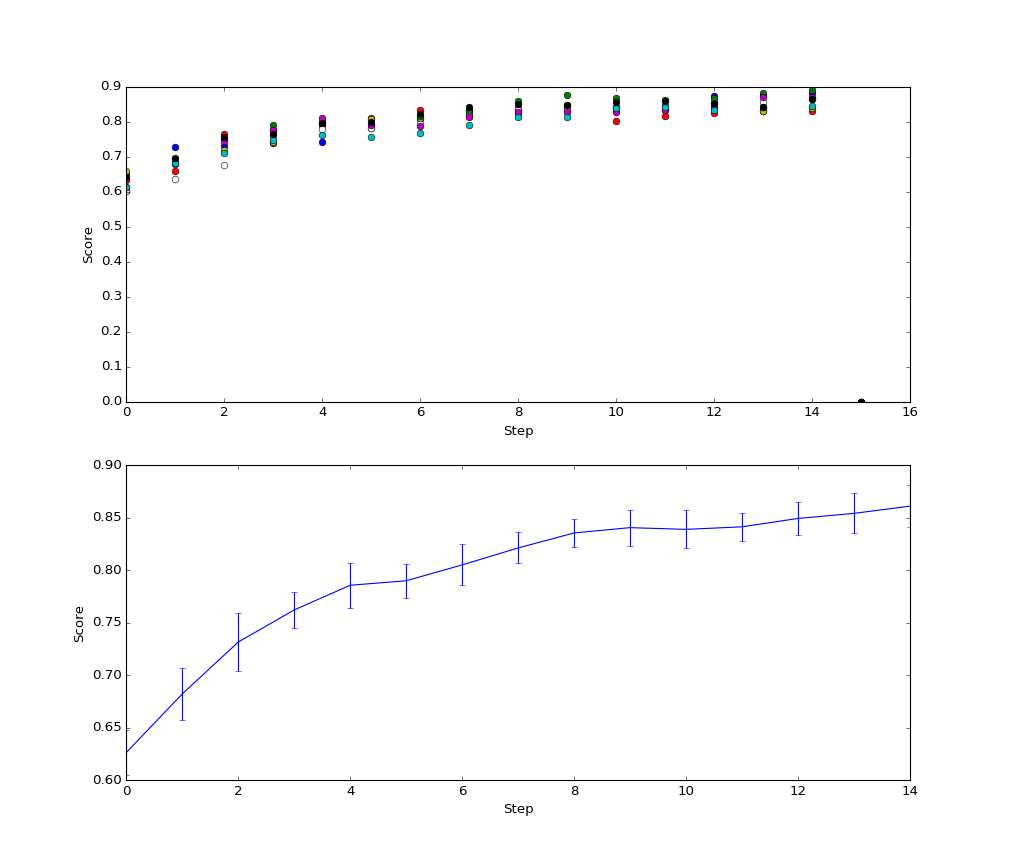

In [6]:
#plt.close('all')
yString = ["lower" if u==-1 else "higher" for u in dfDatasetOrder['rank'].values]
yString = np.array(yString)
#----parEvalS --------------
Xdf = positionBox
X = positionMatrix
y = yString
regType = 'SVC'
poly= 3

kernel = 'poly'

parLabel= "gamma"
labelValue = 20
##OPTIONAL
n_jobs=-1
treeCount = 40
gamma = 1
alpha = 0.1
coef0 = 1
penalty = 0.1
epsilon = 1.95
#---------------------------

k=8
step=15
#

parModel = {"regType":regType, "poly":poly, "kernel":kernel, "treeCount":treeCount, "gamma":gamma, "coef0":coef0, "n_jobs":n_jobs}



dfId = pd.read_csv("data/mut_rand_mod_lib.csv")['ID'] 
dfId = dfId.reindex(np.random.permutation(dfId.index))
lenId = len(dfId)
Id = dfId.values
indexId = np.array(range(lenId))


scores = np.zeros([k,lenId//step])
it=0

for i in range(k):
    indexId = np.array(range(lenId))
    boolTest = np.logical_and(indexId>=i*lenId/k,indexId<(i+1)*lenId/k)
    test = Id[boolTest]
    train = Id[np.invert(boolTest)]
    indexTest = (dfDatasetOrder['ID_1'].isin(test) | dfDatasetOrder['ID_2'].isin(test)).values
    dfDatasetTrain = dfDatasetOrder[np.invert(indexTest)]
    X_train = positionBox[np.invert(indexTest)]
    y_train =  yString[np.invert(indexTest)]
    X_test, y_test = positionBox[indexTest], yString[indexTest]
    #print(np.unique(y_train))
    for j in range((lenId//step)-1):
        print("\rProgress {:2.1%}".format(it/k+(j/(lenId/step)/k)), end='')
        trainInner = train[:(j+1)*step]
        indexTrainInner = (dfDatasetTrain['ID_1'].isin(trainInner) & dfDatasetTrain['ID_2'].isin(trainInner)).values
        X_trainInner, y_trainInner = X_train[indexTrainInner], y_train[indexTrainInner]
        #print(trainInner, sum(indexTrainInner), len(X_trainInner))
        scores[i,j], y_pred = evaluateScore(X_trainInner, X_test, y_trainInner, y_test, {**parModel, parLabel: labelValue})
        
        #plt.scatter(i*(lenId//step)+j,  scores[i*(lenId//step)+j])
    it+=1

    
plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title("Learning curve in sample score")
plt.subplot(211)
for i in range(k):
    colors = ['bo','ro','yo','go','wo','mo','co','ko','bo','co']
    plt.plot(range(lenId//step),scores[i,:], colors[i])
plt.xlabel("Step")
plt.ylabel("Score")
plt.subplot(212)
meanScores=np.mean(scores,axis=0)
stdScores=np.std(scores,axis=0)
plt.errorbar(range(lenId//step-1), meanScores[:-1], stdScores[:-1])
plt.xlabel("Step")
plt.ylabel("Score")


In [ ]:

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(211)
plt.title("Learning curve in sample score for SVM")
for i in range(k):
    colors = ['bo','ro','yo','go','wo','mo','co','ko','bo','co']
    plt.plot(range(lenId//step-1),scores[i,-1], colors[i])
plt.xlabel("Step")
plt.ylabel("Score")
plt.subplot(212)
plt.title("Learning curve in sample score for SVM")
meanScores=np.mean(scores,axis=0)
stdScores=np.std(scores,axis=0)
plt.errorbar(range(lenId//step), meanScores, stdScores)
plt.xlabel("Step")
plt.ylabel("Score")

In [56]:
meanScores

array([ 0.63686852,  0.54872726,  0.61631457,  0.65771903,  0.6942942 ,  0.72124868,  0.70196942,  0.72139706,
        0.73883261,  0.759437  ,  0.75377745,  0.75859915,  0.7833875 ,  0.799236  ,  0.80322729,  0.80389414,
        0.80476709,  0.80208694,  0.80376608,  0.81040844,  0.80420201,  0.80962938,  0.80911927,  0.81430518,
        0.8213178 ,  0.82424539,  0.8240121 ,  0.82088564,  0.82113969,  0.82197217,  0.82649624,  0.83226965,
        0.83096464,  0.83420435,  0.83619804,  0.84333165,  0.84616684,  0.8493075 ,  0.85123508,  0.85327436,
        0.85523033,  0.85523033,  0.85523033,  0.85523033,  0.85523033,  0.85523033,  0.85523033,  0.85523033,
        0.85523033,  0.85523033])

In [ ]:
plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.title("Learning curve in sample score")

colors = ['bo','ro','yo','go','wo','mo','co','ko','bo','co']
meanScores = np.mean()

plt.plot(range(lenId//step),scores[i*(lenId//step):(i+1)*(lenId//step)], colors[i])
plt.xlabel("Step")
plt.ylabel("Score")

In [48]:
np.mean([0,1,2,3])

1.5

<IPython.core.display.Javascript object>


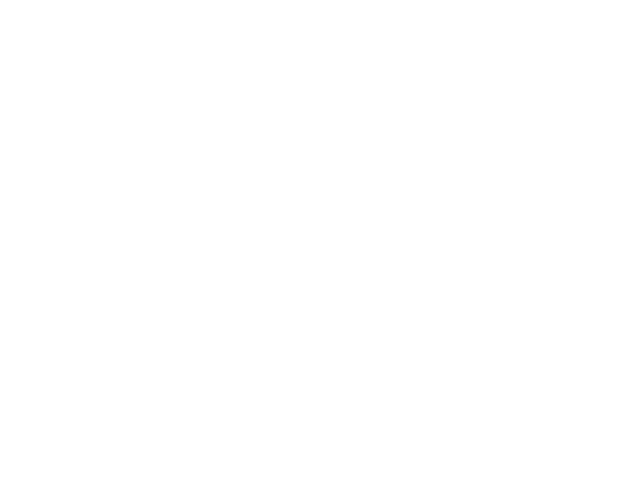

ValueError: x and y must have same first dimension

In [35]:
%matplotlib notebook
plt.title("Learning curve in sample score, stepwise increase of promoter in train library")
for i in range(k):
    colors = ['bo','ro','yo','go','wo','mo','co','ko','bo','co']
    plt.plot(range(len(train)),scores[i*len(train):(i+1)*len(train)], colors[i])
plt.xlabel("Step")
plt.ylabel("Score")

<IPython.core.display.Javascript object>


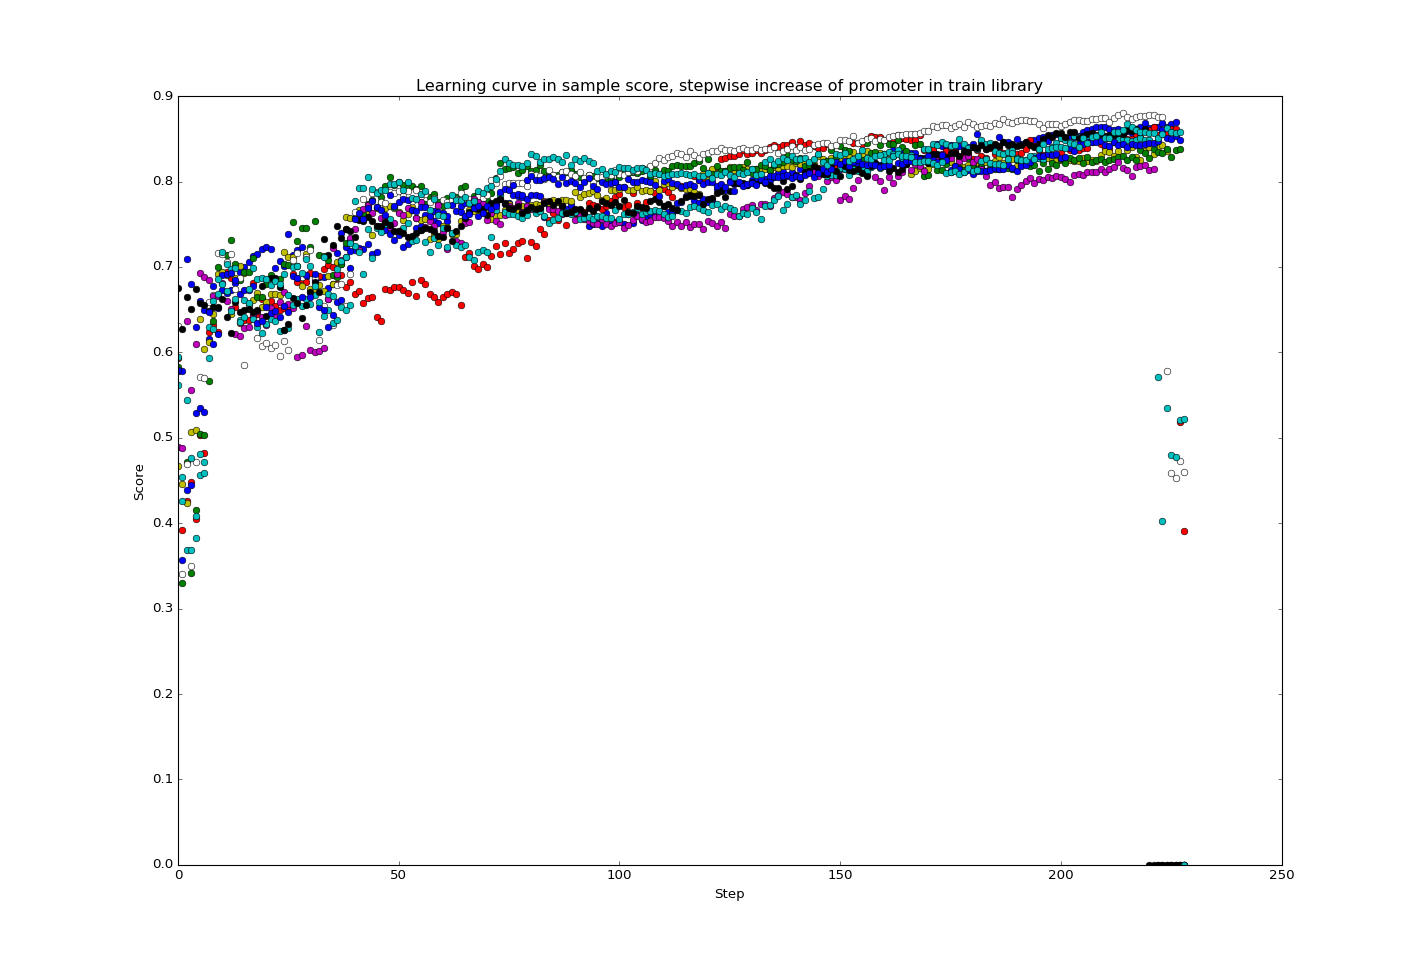

In [101]:

plt.title("Learning curve in sample score, stepwise increase of promoter in train library")
for i in range(k):
    colors = ['bo','ro','yo','go','wo','mo','co','ko','bo','co']
    plt.plot(range(len(train)),scores[i*len(train):(i+1)*len(train)], colors[i])
plt.xlabel("Step")
plt.ylabel("Score")


# Learning Curve out of sample scoring

In [7]:
#######################################################
def loadPairwiseDataset(dataset,ROI,posRange):
    dfDatasetOrder = pd.read_csv(dataset)
    dfDatasetOrder['sequence_1'] = dfDatasetOrder['sequence_1'].str.upper()
    dfDatasetOrder['sequence_2'] = dfDatasetOrder['sequence_2'].str.upper()
    dfDatasetOrder = dfDatasetOrder.reindex(np.random.permutation(dfDatasetOrder.index))
    dfDataset1 = pd.DataFrame(dfDatasetOrder[['ID_1','sequence_1','score_1','35boxstart_1','10boxstart_1']].values,columns=['ID','sequence','mean_score','35boxstart','10boxstart'])
    dfDataset2 = pd.DataFrame(dfDatasetOrder[['ID_2','sequence_2','score_2','35boxstart_2','10boxstart_2']].values,columns=['ID','sequence','mean_score','35boxstart','10boxstart'])

    
    labels1 , positionBoxSeq1, spacerSeq1 = regionSelect(dfDataset1, ROI,posRange)
    labels2 , positionBoxSeq2, spacerSeq2 = regionSelect(dfDataset2, ROI, posRange)

    positionBox = mergePositionDF(positionBoxSeq1, positionBoxSeq2)

    yString = dfDatasetOrder['rank'].values.astype(str)
    
    return positionBox, yString

##########################################################

ROI = [[-5,14],[-8,12]]
posRange = [-42,1]

hammerBox, yHammer = loadPairwiseDataset("data/pw_hammer_prom_lib.csv", ROI, posRange)
brewsterBox, yBrewster = loadPairwiseDataset("data/pw_brewster_prom_lib.csv", ROI, posRange)
andersonBox, yAnderson = loadPairwiseDataset("data/pw_anderson_prom_lib.csv", ROI, posRange)
inbioBox, yInbio = loadPairwiseDataset("data/pw_inbio_prom_lib.csv", ROI, posRange)

In [12]:
#plt.close('all')

#----parEvalS --------------
Xdf = positionBox
X = positionMatrix
y = yString

regType = 'SVC'
poly= 3

kernel = 'poly'

parLabel= "gamma"
labelValue = 20
##OPTIONAL
n_jobs=15
treeCount = 40
gamma = 0.001
alpha = 0.1
coef0 = 0.01
penalty = 0.1
epsilon = 1.95
#---------------------------

#

parModel = {"regType":regType, "poly":poly, "kernel":kernel, "treeCount":treeCount, "gamma":gamma, "coef0":coef0, "n_jobs":n_jobs}

step=50


dfId = pd.read_csv("data/mut_rand_mod_lib.csv")['ID'] 
dfId = dfId.reindex(np.random.permutation(dfId.index))
lenId = len(dfId)
Id = dfId.values
indexId = np.array(range(lenId))


scoresHammer = np.zeros(len(dfId)//step)
scoresBrewster = np.zeros(len(dfId)//step)
scoresAnderson = np.zeros(len(dfId)//step)
scoresInbio = np.zeros(len(dfId)//step)

it=0



for j in range((len(Id)-4)//step):
    print("\rProgress {:2.1%}".format(j/len(Id)/step), end='')

    IdInner = Id[:(j+5)]
    indexTrain= (dfDatasetOrder['ID_1'].isin(IdInner) & dfDatasetOrder['ID_2'].isin(IdInner)).values
    
    X_train, y_train = positionBox[indexTrain], yString[indexTrain]
    #print(trainInner, sum(indexTrainInner), len(X_trainInner))
    scoresHammer[j], y_pred = evaluateScore(X_train, hammerBox.values, y_train, yHammer, {**parModel, parLabel: labelValue})
    scoresBrewster[j], y_pred = evaluateScore(X_train, brewsterBox.values, y_train, yBrewster, {**parModel, parLabel: labelValue})
    scoresAnderson[j], y_pred = evaluateScore(X_train, andersonBox.values, y_train, yAnderson, {**parModel, parLabel: labelValue})
    scoresInbio[j], y_pred = evaluateScore(X_train, inbioBox.values, y_train, yInbio, {**parModel, parLabel: labelValue})
    
    
    
    
plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.title("Learning curve out of sample score")
colors = ['bo','ro','yo','go','wo','mo','co','ko','bo','co']
plt.plot(range(len(dfId)//step),scoresHammer[:len(dfId)], colors[0], label="Hammer")
plt.plot(range(len(dfId)//step),scoresBrewster[:len(dfId)], colors[1], label="Brewster")
plt.plot(range(len(dfId)//step),scoresAnderson[:len(dfId)], colors[2], label="Anderson")
plt.plot(range(len(dfId)//step),scoresInbio[:len(dfId)], colors[3], label="Inbio")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Score")




Progress 0.0%

TypeError: only integer arrays with one element can be converted to an index

In [12]:
scoresBrewster

array([ 0.,  0.,  0.,  0.,  0.])

In [ ]:
plt.title("Learning curve out of sample score")
colors = ['bo','ro','yo','go','wo','mo','co','ko','bo','co']
plt.plot(range(len(dfId)),scoresHammer[:len(dfId)], colors[0], label="Hammer")
plt.plot(range(len(dfId)),scoresBrewster[:len(dfId)], colors[1], label="Brewster")
plt.plot(range(len(dfId)),scoresAnderson[:len(dfId)], colors[2], label="Anderson")
plt.plot(range(len(dfId)),scoresInbio[:len(dfId)], colors[3], label="Inbio")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Score")


<IPython.core.display.Javascript object>


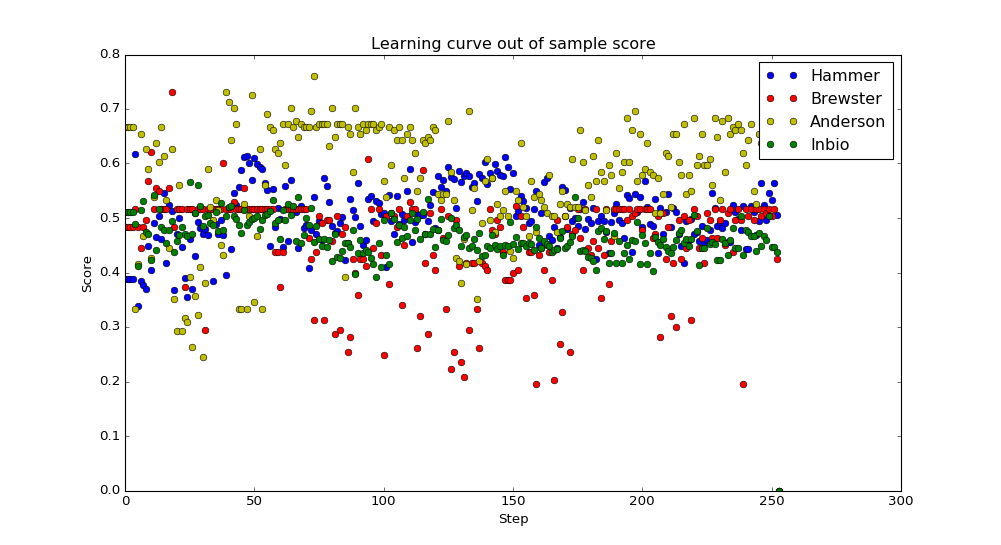

In [115]:
%matplotlib notebook
plt.title("Learning curve out of sample score")
colors = ['bo','ro','yo','go','wo','mo','co','ko','bo','co']
plt.plot(range(len(dfId)),scoresHammer[:len(dfId)], colors[0], label="Hammer")
plt.plot(range(len(dfId)),scoresBrewster[:len(dfId)], colors[1], label="Brewster")
plt.plot(range(len(dfId)),scoresAnderson[:len(dfId)], colors[2], label="Anderson")
plt.plot(range(len(dfId)),scoresInbio[:len(dfId)], colors[3], label="Inbio")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Score")


# Learning curve (two) merged training  datasets

In [ ]:
#plt.close('all')

#----parEvalS --------------
Xdf = positionBox
X = positionMatrix
Xenrich = hammerBox.values 
dfDatasetHammer = pd.read_csv("data/pw_hammer_prom_lib.csv")
y = yString

regType = 'forestClass'
poly= None

kernel = None

parLabel= "max_depth"
labelValue = 10
##OPTIONAL
n_jobs=15
treeCount = 40
gamma = 0.001
alpha = 0.1
coef0 = 0.01
penalty = 0.1
epsilon = 1.95
#---------------------------

#

parModel = {"regType":regType, "poly":poly, "kernel":kernel, "treeCount":treeCount, "gamma":gamma, "coef0":coef0, "n_jobs":n_jobs}



dfId = pd.read_csv("data/hammer_lib.csv")['ID'] 
dfId = dfId.reindex(np.random.permutation(dfId.index))
lenId = len(dfId)
Id = dfId.values
indexId = np.array(range(lenId))


#scoresHammer = np.zeros(len(X_train)*k)
scoresBrewster = np.zeros(len(X_train)*k)
scoresAnderson = np.zeros(len(X_train)*k)
scoresInbio = np.zeros(len(X_train)*k)

it=0

plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.ion()


for j in range(len(Id)):
    print("\rProgress {:2.1%}".format(j/len(Id)), end='')
    IdInner = Id[:(j+2)]
    indexTrain= (dfDatasetHammer['ID_1'].isin(IdInner) & dfDatasetHammer['ID_2'].isin(IdInner)).values
    X_append, y_append = Xenrich[indexTrain], yHammer[indexTrain]
    X_train, y_train = np.vstack((positionBox,X_append)), np.hstack((yString,y_append))
    #print(trainInner, sum(indexTrainInner), len(X_trainInner))
    #scoresHammer[j], y_pred = evaluateScore(X_train, hammerBox.values, y_train, yHammer, {**parModel, parLabel: labelValue})
    scoresBrewster[j], y_pred = evaluateScore(X_train, brewsterBox.values, y_train, yBrewster, {**parModel, parLabel: labelValue})
    scoresAnderson[j], y_pred = evaluateScore(X_train, andersonBox.values, y_train, yAnderson, {**parModel, parLabel: labelValue})
    scoresInbio[j], y_pred = evaluateScore(X_train, inbioBox.values, y_train, yInbio, {**parModel, parLabel: labelValue})
    
    

plt.title("Learning curve out of sample score")
colors = ['bo','ro','yo','go','wo','mo','co','ko','bo','co']
#plt.plot(range(len(dfId)),scoresHammer[:len(dfId)], colors[0], label="Hammer")
plt.plot(range(len(dfId)),scoresBrewster[:len(dfId)], colors[1], label="Brewster")
plt.plot(range(len(dfId)),scoresAnderson[:len(dfId)], colors[2], label="Anderson")
plt.plot(range(len(dfId)),scoresInbio[:len(dfId)], colors[3], label="Inbio")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Score")




  

# K-fold cross validation ranked data

<IPython.core.display.Javascript object>


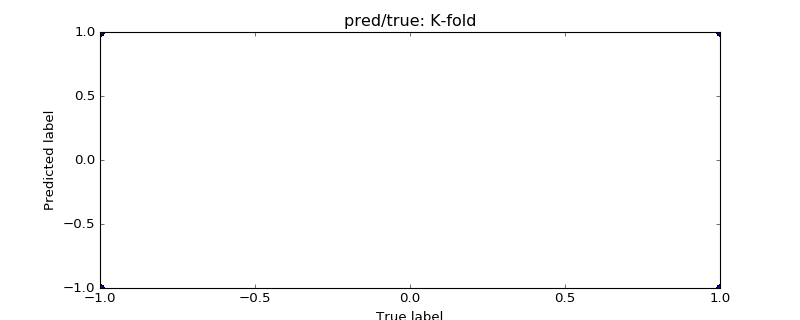

 Progress 0.0%(33153,)
(33153,)
 Progress 50.0%(33153,)
(33153,)


In [15]:
#plt.close('all')

#----parEvalS --------------
Xdf = positionBox
X = positionMatrix
y = yString

regType = 'SVC'
poly= 3

kernel = 'poly'
parLabel = 'gamma'
parRange = 2

testSize = 0.20 
k = 2
kInner = 5
pdf = None


##OPTIONAL
n_jobs=8
treeCount = 40
gamma = 1
alpha = 0.1
coef0 = 1
penalty = 0.1
epsilon = 1
#---------------------------


parModel = {"regType":regType, "poly":poly, "kernel":kernel, "treeCount":treeCount, 
            "coef0":coef0, "n_jobs":n_jobs, "epsilon":epsilon, "C":1}

#



dfId = pd.read_csv("data/mut_rand_mod_lib.csv")['ID'] 
dfId = dfId.reindex(np.random.permutation(dfId.index))
lenId = len(dfId)
Id = dfId.values
indexId = np.array(range(lenId))




scoresPar = np.zeros([k,parRange])
optimalPar = np.zeros([k])
plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')

for i in range(k):
    print("\r Progress {:2.1%}".format(i/k), end="")
    test = np.squeeze(Id[i*lenId/k:(i+1)*lenId/k])
    index = (dfDatasetOrder['ID_1'].isin(test) | dfDatasetOrder['ID_2'].isin(test)).values
    print(np.shape(index))
    print(np.shape(yString))
    X_train = positionBox[np.invert(index)]
    y_train = yString[np.invert(index)]
    X_test, y_test = positionBox[index], yString[index]
    scoresPar[i,:], optimalPar[it] = evaluateSinglePar(X_train.values, X_test.values, y_train, y_test, parModel, parLabel, [parRange])
    score, y_pred = evaluateScore(X_train, X_test, y_train, y_test, {**parModel, parLabel: optimalPar[it]})
    plt.title("pred/true: K-fold")
    plt.plot(y_test,y_pred, 'bo')
    plt.xlabel("True label")
    plt.ylabel("Predicted label")

    

#scores = np.transpose(scoresM)

    
meanScores = np.mean(np.ndarray.max(scoresPar,axis=1))


<IPython.core.display.Javascript object>


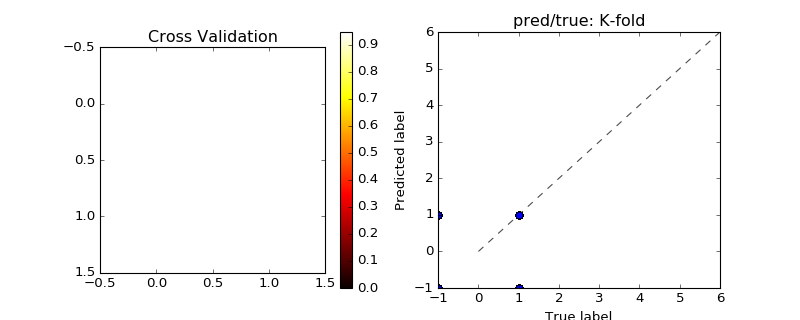

K FOLD CV 
---------- 

 Maximum Score:  0.947755791506 
 Mean optimal score:  0.947123959576 
 sd optimal scores:  0.0008935452838760073 
 Optimal parEval:
 [ 0.1  0.1] 
 parEval Scores:
 [[ 0.94649213  0.94492369]
 [ 0.94775579  0.94660956]] 





In [6]:
#plt.close('all')

#----parEvalS --------------
Xdf = positionBox
X = positionMatrix
y = yString

regType = 'SVC'
poly= 3

kernel = 'poly'
parLabel = ['C']
parRange = [2]

k = 2
kInner = 5


##OPTIONAL
n_jobs=8
treeCount = 40
gamma = 0.1
alpha = 0.1
coef0 = 1
penalty = 0.1
epsilon = 1
#---------------------------

parModel = {"regType":regType, "poly":poly, "kernel":kernel, "treeCount":treeCount, "coef0":coef0, 'gamma':gamma}


#

if len(parLabel) is 1: 
    scoresParCV, optimalParCV = KfoldCV(X,y,k,parModel,parLabel[0],parRange[0]) 
    #scoresParNCV, optimalParNCV, scoresNCV = nestedKfoldCV(X,y,k,kInner,parModel,parLabel[0],parRange[0])    
    meanScores = np.mean(np.ndarray.max(scoresParCV,axis=1))
    print("K FOLD CV \n---------- \n\n Maximum Score: ",np.max(scoresParCV), "\n Mean optimal score: ", meanScores ,"\n sd optimal scores: ", math.sqrt(np.sum(np.power((np.ndarray.max(scoresParCV,axis=1)-meanScores),2)))   , "\n Optimal parEval:\n", optimalParCV, "\n parEval Scores:\n", scoresParCV,"\n\n\n")
    #print("NESTED K FOLD CV \n----------------- \n\n Maximum Score: ",np.max(scoresParNCV), "\n Mean optimal score: ", np.mean(scoresParNCV) ,"\n sd optimal scores: ", math.sqrt(np.sum(np.power((np.ndarray.max(scoresParCV,axis=1)-np.mean(scoresParNCV)),2))) , "\n Optimal parEval:\n", optimalParNCV, "\n parEval Scores:\n", scoresParNCV,"\n\n\n")

if len(parLabel) is 2:
    evaluateMultiPar(X, y, parModel, parLabel, parRange)

    

array([-1, -1,  1, ..., -1,  1,  1], dtype=int8)

In [30]:
dfDatasetTest = querySQL('prom_test_data', 'SELECT  sequence, mean_score, 35boxstart, 10boxstart, ID  FROM brewster_prom_lib')
dfDatasetTest['sequence'] = dfDatasetTest['sequence'].str.upper()

dfDatasetOrder = dfDatasetTest

DF = pd.DataFrame(index=range(int(len(dfDatasetOrder)*(len(dfDatasetOrder)-1)/2)), columns=['ID_1','ID_2','sequence_1','sequence_2'])

In [31]:
for i in range(len(dfDatasetOrder)):
    ID = dfDatasetOrder.iloc[i,4]
    DF.iloc[i*(len(dfDatasetOrder)-1):(i+1)*len(dfDatasetOrder),0] = ID

ZIP = list(itertools.combinations(dfDatasetOrder.iloc[:,4],2))

DF['ID_1'] = [item[0] for item in ZIP]
DF['ID_2'] = [item[1] for item in ZIP]

DF['sequence_1'] = [dfDatasetOrder[dfDatasetOrder['ID']==x]['sequence'].values[0] for x in DF['ID_1']]
DF['sequence_2'] = [dfDatasetOrder[dfDatasetOrder['ID']==x]['sequence'].values[0] for x in DF['ID_2']]

DF['score_1'] = [dfDatasetOrder[dfDatasetOrder['ID']==x]['mean_score'].values[0] for x in DF['ID_1']]
DF['score_2'] = [dfDatasetOrder[dfDatasetOrder['ID']==x]['mean_score'].values[0] for x in DF['ID_2']]

DF['rank'] = [1 if x>(DF.iloc[i]['score_2']) else -1 for i, x in enumerate(DF['score_1']) ]

DF['35boxstart_1'] = [dfDatasetOrder[dfDatasetOrder['ID']==x]['35boxstart'].values[0] for x in DF['ID_1']]
DF['35boxstart_2'] = [dfDatasetOrder[dfDatasetOrder['ID']==x]['35boxstart'].values[0] for x in DF['ID_2']]

DF['10boxstart_1'] = [dfDatasetOrder[dfDatasetOrder['ID']==x]['10boxstart'].values[0] for x in DF['ID_1']]
DF['10boxstart_2'] = [dfDatasetOrder[dfDatasetOrder['ID']==x]['10boxstart'].values[0] for x in DF['ID_2']]

In [32]:
dfDataset1Train = pd.DataFrame(DF[['ID_1','sequence_1','score_1','35boxstart_1','10boxstart_1']].values,columns=['ID','sequence','mean_score','35boxstart','10boxstart'])
dfDataset2Train = pd.DataFrame(DF[['ID_2','sequence_2','score_2','35boxstart_2','10boxstart_2']].values,columns=['ID','sequence','mean_score','35boxstart','10boxstart'])


In [34]:
posRange = [-42,1]
label1Test , positionBoxSeq1_test, spacerSeq1_test = regionSelect(dfDataset1Train, [[-5,14],[-8,12]], posRange)
label2Test , positionBoxSeq2_test, spacerSeq2_test = regionSelect(dfDataset2Train, [[-5,14],[-8,12]], posRange)

positionBox_test = mergePositionDF(positionBoxSeq1_test, positionBoxSeq2_test)

positionMatrix_test = positionBox_test.values

In [35]:

X_test = positionMatrix_test 
y_TestString = DF["rank"].values.astype(str)

In [39]:
clf = svm.SVC(kernel='rbf', C=.1)

clf.fit(X,yString)

predict = clf.predict(X_test)
clf.score(X_test,y_TestString)


0.26797385620915032

In [29]:

treeCount = 100

clf = selectRegression(**parModelFinal)
clf.fit(X,y)
y_predict = clf.predict(X_test)


In [28]:

yData = DF.values[:,6]
yData = np.asarray(yData, dtype="|S6")


print(sum(yData == y_predict))
print(np.size(yData))

77
171


In [17]:
y_predict

array([b'-1', b'1', b'-1', b'1', b'-1', b'1', b'-1', b'-1', b'1', b'-1', b'1', b'-1', b'-1', b'-1', b'-1', b'-1', b'1',
       b'1', b'-1', b'-1', b'-1', b'1', b'-1', b'-1', b'-1', b'1', b'-1', b'-1', b'-1', b'-1', b'1', b'-1', b'-1',
       b'-1', b'-1', b'-1', b'1', b'-1', b'1', b'1', b'-1', b'1', b'-1', b'1', b'-1', b'-1', b'-1', b'-1', b'-1', b'1',
       b'1', b'1', b'1', b'1', b'1', b'-1', b'1', b'1', b'-1', b'-1', b'1', b'1', b'1', b'-1', b'1', b'1', b'-1', b'1',
       b'1', b'-1', b'1', b'1', b'1', b'-1', b'-1', b'1', b'1', b'-1', b'1', b'1', b'-1', b'-1', b'-1', b'1', b'1',
       b'-1', b'-1', b'-1', b'1', b'-1', b'-1', b'-1', b'-1', b'-1', b'-1', b'1', b'1', b'-1', b'-1', b'-1', b'1',
       b'-1', b'-1', b'-1', b'-1', b'-1', b'1', b'1', b'-1', b'-1', b'-1', b'1', b'-1', b'-1', b'1', b'-1', b'1', b'1',
       b'1', b'1', b'1', b'1', b'1', b'1', b'1', b'1', b'1', b'-1', b'-1', b'-1', b'1', b'-1', b'-1', b'-1', b'-1',
       b'-1', b'-1', b'-1', b'1', b'-1', b'-1', b'1', b'1'

In [45]:
0.8*0.69+0.1*0.49+0.1*0.75

0.6759999999999999

In [ ]:
0.8*0.75+0.1*0.+0.1*0.75

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
